In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import sys
import matplotlib.pyplot as plt


import tensorflow_hub as hub
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATA_DIR = "../input/food41/images"

TRAIN_DATA_DIR = "drive/MyDrive/Google developer/Dataset2/training"
TEST_DATA_DIR = "drive/MyDrive/Google developer/Dataset2/validation"
VAL_DATA_DIR = "drive/MyDrive/Google developer/Dataset2/evaluation"
BATCH_SIZE=32
OUTPUT_FIGURE_DIR = "./"

def train_val_generators(TRAIN_DIR, TEST_DIR,VAL_DIR, NUM_BATCHES):
    """

    :param DATA_DIR: Directory of the datasets was taken from (string)
    :param SPLIT_SIZE: Split size of test set. (float)
    :param NUM_BATCHES: Amount of batch size
    :return:
    """
    
    
    train_generator = tf.keras.preprocessing.image_dataset_from_directory(directory=TRAIN_DIR,
                                                  batch_size=NUM_BATCHES,
                                                  label_mode='categorical',
                                                  image_size=(224, 224),
                                                    

    )

    test_generator = tf.keras.preprocessing.image_dataset_from_directory(directory=TEST_DIR,
                                                       batch_size=NUM_BATCHES,
                                                       label_mode='categorical',
                                                       image_size=(224, 224))

    validation_generator = tf.keras.preprocessing.image_dataset_from_directory(directory=VAL_DIR,
                                                       batch_size=NUM_BATCHES,
                                                       label_mode='categorical',
                                                       image_size=(224, 224))

    return train_generator,test_generator, validation_generator

In [3]:
train_ds, test_ds, val_ds = train_val_generators(TRAIN_DATA_DIR, TEST_DATA_DIR,VAL_DATA_DIR, BATCH_SIZE)

Found 9883 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.
Found 3347 files belonging to 11 classes.


In [4]:
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

In [5]:
def plot_accuracy(history, output_dir, model_name):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/accuracy_{model_name}")
    plt.show()
    
def plot_loss(history, output_dir, model_name):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/loss_{model_name}")
    plt.show()

In [6]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
     preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name='data_augmentation')

In [7]:
# Set checkpoint path

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # Save for every epochs
                                                         verbose=1
                                                         )

In [8]:
# Setup input shape and base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable =  False

# Create inputt layers
inputs = tf.keras.Input(shape=input_shape)

# Data augmentation
x = data_augmentation(inputs)

# Give base model input after augmentation 
x = base_model(x, training=False)

# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model_efficientnet_1 =  Model(inputs, outputs)

# Compile
model_efficientnet_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model_efficientnet_1.summary()

258076736/258076736 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 11)                28171     
                                                            

In [9]:
model_efficientnet_1.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

csv_logger_feature_extraction = tf.keras.callbacks.CSVLogger("./LOG_CSV_EFFICIENTNETB7_FEATURE_EXTRACTION.log")
csv_logger_fine_tune = tf.keras.callbacks.CSVLogger("./LOG_CSV_EFFICIENTNETB7_FINE_TUNE.log")

model_efficientnet_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 11)                28171     
                                                                 
Total params: 64,125,858
Trainable params: 28,171
Non-trainab

In [10]:
initial_epochs=10
history_model_efficientnet_1_feature_extraction = model_efficientnet_1.fit(train_ds, 
                                                                     epochs=initial_epochs,
                                                                     validation_data=test_ds, 
                                                                     callbacks=[csv_logger_feature_extraction])

Epoch 1/10
309/309 [==============================] - 2889s 9s/step - loss: 0.8752 - accuracy: 0.7324 - val_loss: 0.5706 - val_accuracy: 0.8227
Epoch 2/10
309/309 [==============================] - 253s 817ms/step - loss: 0.5778 - accuracy: 0.8137 - val_loss: 0.5005 - val_accuracy: 0.8423
Epoch 3/10
309/309 [==============================] - 232s 750ms/step - loss: 0.5181 - accuracy: 0.8335 - val_loss: 0.4707 - val_accuracy: 0.8519
Epoch 4/10
309/309 [==============================] - 226s 730ms/step - loss: 0.4723 - accuracy: 0.8454 - val_loss: 0.4561 - val_accuracy: 0.8528
Epoch 5/10
309/309 [==============================] - 215s 693ms/step - loss: 0.4472 - accuracy: 0.8534 - val_loss: 0.4305 - val_accuracy: 0.8653
Epoch 6/10
309/309 [==============================] - 210s 677ms/step - loss: 0.4354 - accuracy: 0.8563 - val_loss: 0.4282 - val_accuracy: 0.8598
Epoch 7/10
309/309 [==============================] - 209s 676ms/step - loss: 0.4207 - accuracy: 0.8608 - val_loss: 0.4145 - v

Text(0.5, 1.0, 'Model EfficientNet Exp 1')

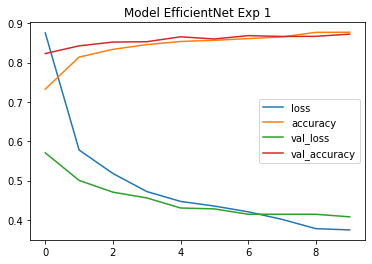

In [11]:
pd.DataFrame(history_model_efficientnet_1_feature_extraction.history).plot()
plt.title("Model EfficientNet Exp 1")

In [5]:
KERAS_MODEL_NAME= "tf_food_mnist.h5"
model_efficientnet_1=tf.keras.models.load_model(KERAS_MODEL_NAME)

In [6]:
model_efficientnet_1.save(KERAS_MODEL_NAME)

In [7]:
test_loss,test_acc= model_efficientnet_1.evaluate(test_ds, verbose=2)
print("Test accuracy:",test_acc)

NameError: ignored

In [8]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model_opt.tflite"

In [9]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model_efficientnet_1)

In [10]:
### Optimized for low MB
tf_lite_converter.optimizations=[tf.lite.Optimize.DEFAULT]

In [11]:
tflite_model = tf_lite_converter.convert()

In [12]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

67418808

In [20]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 11]
Output Type: <class 'numpy.float32'>


In [27]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 11))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 11]
Output Type: <class 'numpy.float32'>
